In [1]:
from sift import *
from VFX_HW2 import *

In [2]:
name = 'library_0513'
# name = 'parrington'
data_path = 'data/' + name # 'parrington'# 
file_name = data_path + f'/{name}.txt' #'pano_list.txt'#
# file_name = data_path + '/pano_list.txt'

In [3]:
imglist, focals = parse(data_path, file_name)

In [4]:
# cylinderImgs = [cylinderProject(imglist[i], focals[i]) for i in range(len(imglist))]
pool = mp.Pool(mp.cpu_count()//2)
cylinderImgs = pool.starmap(cylinderProject, [(imglist[i], focals[i]*2) for i in range(len(imglist))])
cylinderImgs = [cv2.resize(i, (i.shape[1]//2, i.shape[0]//2)) for i in cylinderImgs]
grayImgs = [cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in cylinderImgs]
kp_des = pool.starmap(SIFT, [(i, 1.6, 5, 4, None, .3) for i in grayImgs])
# kp_des = [SIFT(i) for i in grayImgs]

Removed: 0, Remained: 0
Skip 1
Removed: 109, Remained: 1357
Removed: 289, Remained: 3080
Removed: 284, Remained: 2413
Removed: 0, Remained: 0Removed: 0, Remained: 0Removed: 0, Remained: 0
Skip 1Removed: 0, Remained: 0



Removed: 0, Remained: 0
Skip 1
Skip 1Skip 1
Skip 1

Removed: 3, Remained: 4
Removed: 0, Remained: 0
Skip 1
Removed: 0, Remained: 2Removed: 0, Remained: 1

Removed: 0, Remained: 1Removed: 0, Remained: 2

Removed: 3, Remained: 25Removed: 0, Remained: 1

Removed: 0, Remained: 0
Skip 1
Removed: 0, Remained: 0Removed: 2, Remained: 24
Skip 1

Removed: 3, Remained: 100
Removed: 52, Remained: 432Removed: 491, Remained: 5159
Removed: 1, Remained: 35

Removed: 14, Remained: 278Removed: 0, Remained: 10

Removed: 0, Remained: 0Removed: 0, Remained: 3Removed: 60, Remained: 1071Removed: 332, Remained: 2478
Skip 2
Removed: 15, Remained: 449

Removed: 12, Remained: 191

Removed: 146, Remained: 1218
Removed: 291, Remained: 5322Removed: 132, Remained: 2441


Removed: 4, Remained: 130
Re

In [5]:
xshape = 0
shifts = []
ConcateImg = cylinderImgs[0].copy()
for i in range(1, len(cylinderImgs)):
    print(f"========================{i-1}")
    r_image = cylinderImgs[i-1]
    xshape += r_image.shape[1]

    l_image = cylinderImgs[i]
    shifts.append(stitch(*kp_des[i], *kp_des[i-1], min_matches=30))
    ConcateImg = blend(l_image, ConcateImg, shifts[-1])
    print("==========================================================")
cv2.imwrite('output.jpg', ConcateImg)

========================0
Good Matches: 193, threshold=0.6
shift
[265   7]
========================1
Good Matches: 110, threshold=0.6
shift
[290   8]
========================2
Good Matches: 124, threshold=0.6
shift
[237   8]
========================3
Good Matches: 339, threshold=0.6
shift
[251   6]
========================4
Good Matches: 261, threshold=0.6
shift
[222   7]
========================5
Good Matches: 229, threshold=0.6
shift
[329   9]
========================6
Good Matches: 391, threshold=0.6
shift
[270   8]
========================7
Good Matches: 488, threshold=0.6
shift
[243   7]
========================8
Good Matches: 835, threshold=0.6
shift
[189   6]
========================9
Good Matches: 600, threshold=0.6
shift
[214   7]
========================10
Good Matches: 251, threshold=0.6
shift
[339  10]
========================11
Good Matches: 388, threshold=0.6
shift
[287   9]
========================12
Good Matches: 287, threshold=0.6
shift
[128  18]
======================

True

In [6]:
mimg = [i.astype(np.float32)/255 for i in cylinderImgs]
gimgs = []
for i in range(len(mimg)-1):
    gimg = queryPoints([kp_des[i+1][1], kp_des[i][1]], [kp_des[i+1][0], kp_des[i][0]], min_matches=-1, ret_match_img=mimg[i:i+2][::-1])[2]
    gimgs.append(gimg[..., ::-1])

Good Matches: 193, threshold=0.6
Good Matches: 110, threshold=0.6
Good Matches: 124, threshold=0.6
Good Matches: 339, threshold=0.6
Good Matches: 261, threshold=0.6
Good Matches: 229, threshold=0.6
Good Matches: 391, threshold=0.6
Good Matches: 488, threshold=0.6
Good Matches: 835, threshold=0.6
Good Matches: 600, threshold=0.6
Good Matches: 251, threshold=0.6
Good Matches: 388, threshold=0.6
Good Matches: 287, threshold=0.6
Good Matches: 135, threshold=0.6
Good Matches: 43, threshold=0.6
Good Matches: 98, threshold=0.6
Good Matches: 82, threshold=0.6


""

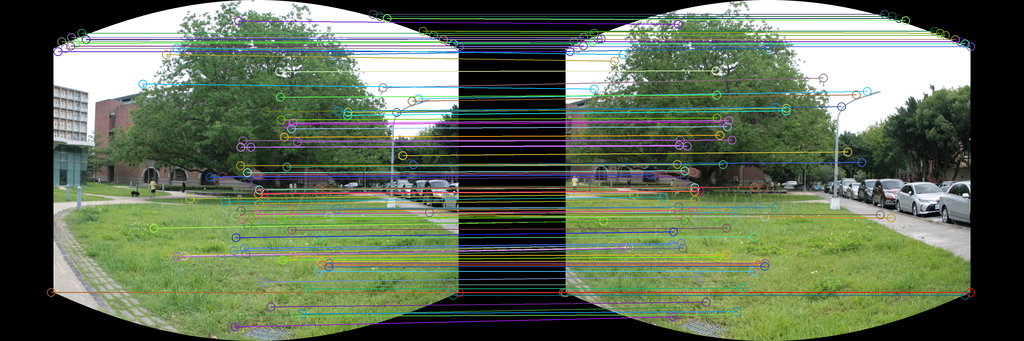

In [7]:
media.show_image(gimgs[1], width=1024)
# media.show_images(gimgs, columns=1, width=1024)
# for i in gimgs:
    # media.show_image(i, width=1024)